In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold


In [2]:
df = pd.read_csv('creditcard.csv')

In [3]:
class_distribution = df['Class'].value_counts()
print(class_distribution)

Class
0    284315
1       492
Name: count, dtype: int64


In [4]:
df.isnull().sum().max()

0

In [5]:
# Since most of our data has already been scaled we should scale the columns that are left to scale (Amount and Time)
from sklearn.preprocessing import StandardScaler, RobustScaler

# RobustScaler is less prone to outliers.

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)

In [6]:
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

# Amount and Time are Scaled!

df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


In [7]:
df.to_pickle('your_dataframe.pkl')

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

X = df.drop('Class', axis=1)
y = df['Class']

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

# We already have X_train and y_train for undersample data thats why I am using original to distinguish and to not overwrite these variables.
# original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the Distribution of the labels


# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset
Train: [ 30473  30496  31002 ... 284804 284805 284806] Test: [    0     1     2 ... 57017 57018 57019]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 30473  30496  31002 ... 113964 113965 113966]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 81609  82400  83053 ... 170946 170947 170948]
Train: [     0      1      2 ... 284804 284805 284806] Test: [150654 150660 150661 ... 227866 227867 227868]
Train: [     0      1      2 ... 227866 227867 227868] Test: [212516 212644 213092 ... 284804 284805 284806]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99827076 0.00172924]
[0.99827952 0.00172048]


In [9]:
df.to_pickle('your_dataframe.pkl')


In [10]:
# Since our classes are highly skewed we should make them equivalent in order to have a normal distribution of the classes.

# Lets shuffle the data before creating the subsamples

df = df.sample(frac=1)

# amount of fraud classes 492 rows.
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
2251,-0.111926,-0.973989,-0.356599,0.852213,1.599082,1.147261,0.270957,0.415114,0.675715,0.088268,...,0.159197,-0.045032,0.328856,-0.184821,0.015335,-0.178618,-0.266244,0.254932,-0.030987,0
23422,9.713547,-0.610287,-2.179135,0.020218,-2.182733,2.572046,-3.663733,0.081568,0.268049,0.660437,...,1.957960,1.026421,0.299614,1.656800,0.328433,0.106457,0.691775,0.196779,0.241085,1
140000,0.586879,-0.014251,1.167944,-0.358123,0.256857,-0.156022,-0.518942,-0.204091,-0.345445,0.121323,...,-0.001233,-0.230213,-0.926484,0.028407,-0.510294,0.007567,0.776736,-0.093204,0.002241,0
149587,-0.293440,0.080264,1.954852,1.630056,-4.337200,2.378367,2.113348,-1.583851,0.653745,-0.192892,...,-0.230640,-0.474437,-0.974625,-0.048155,-0.023524,0.362192,-0.570709,0.025619,0.081880,1
192687,3.551596,0.530034,1.522080,-0.519429,-2.581685,0.774741,0.206722,-1.431020,0.757011,-0.444418,...,0.361169,0.019649,-0.211678,-0.247452,-0.279472,0.239646,-0.508398,-0.015551,0.041881,1


Distribution of the Classes in the subsample dataset
Class
0    0.5
1    0.5
Name: count, dtype: float64


C:\Users\husania\AppData\Local\Temp\ipykernel_3900\1962062015.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = 'Class', data=new_df, palette=colors)


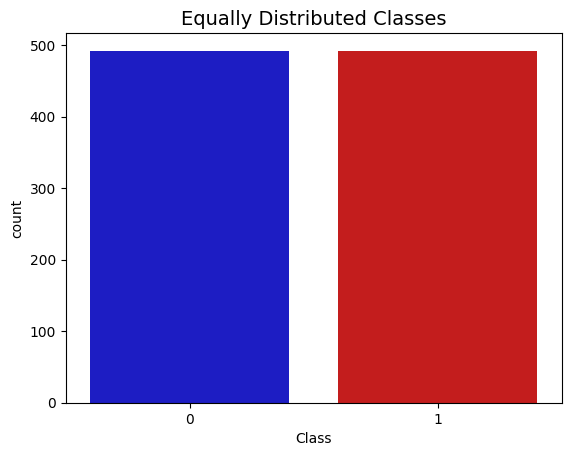

In [11]:
colors = ["#0101DF", "#DF0101"]
print('Distribution of the Classes in the subsample dataset')
print(new_df['Class'].value_counts()/len(new_df))



sns.countplot(x = 'Class', data=new_df, palette=colors)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

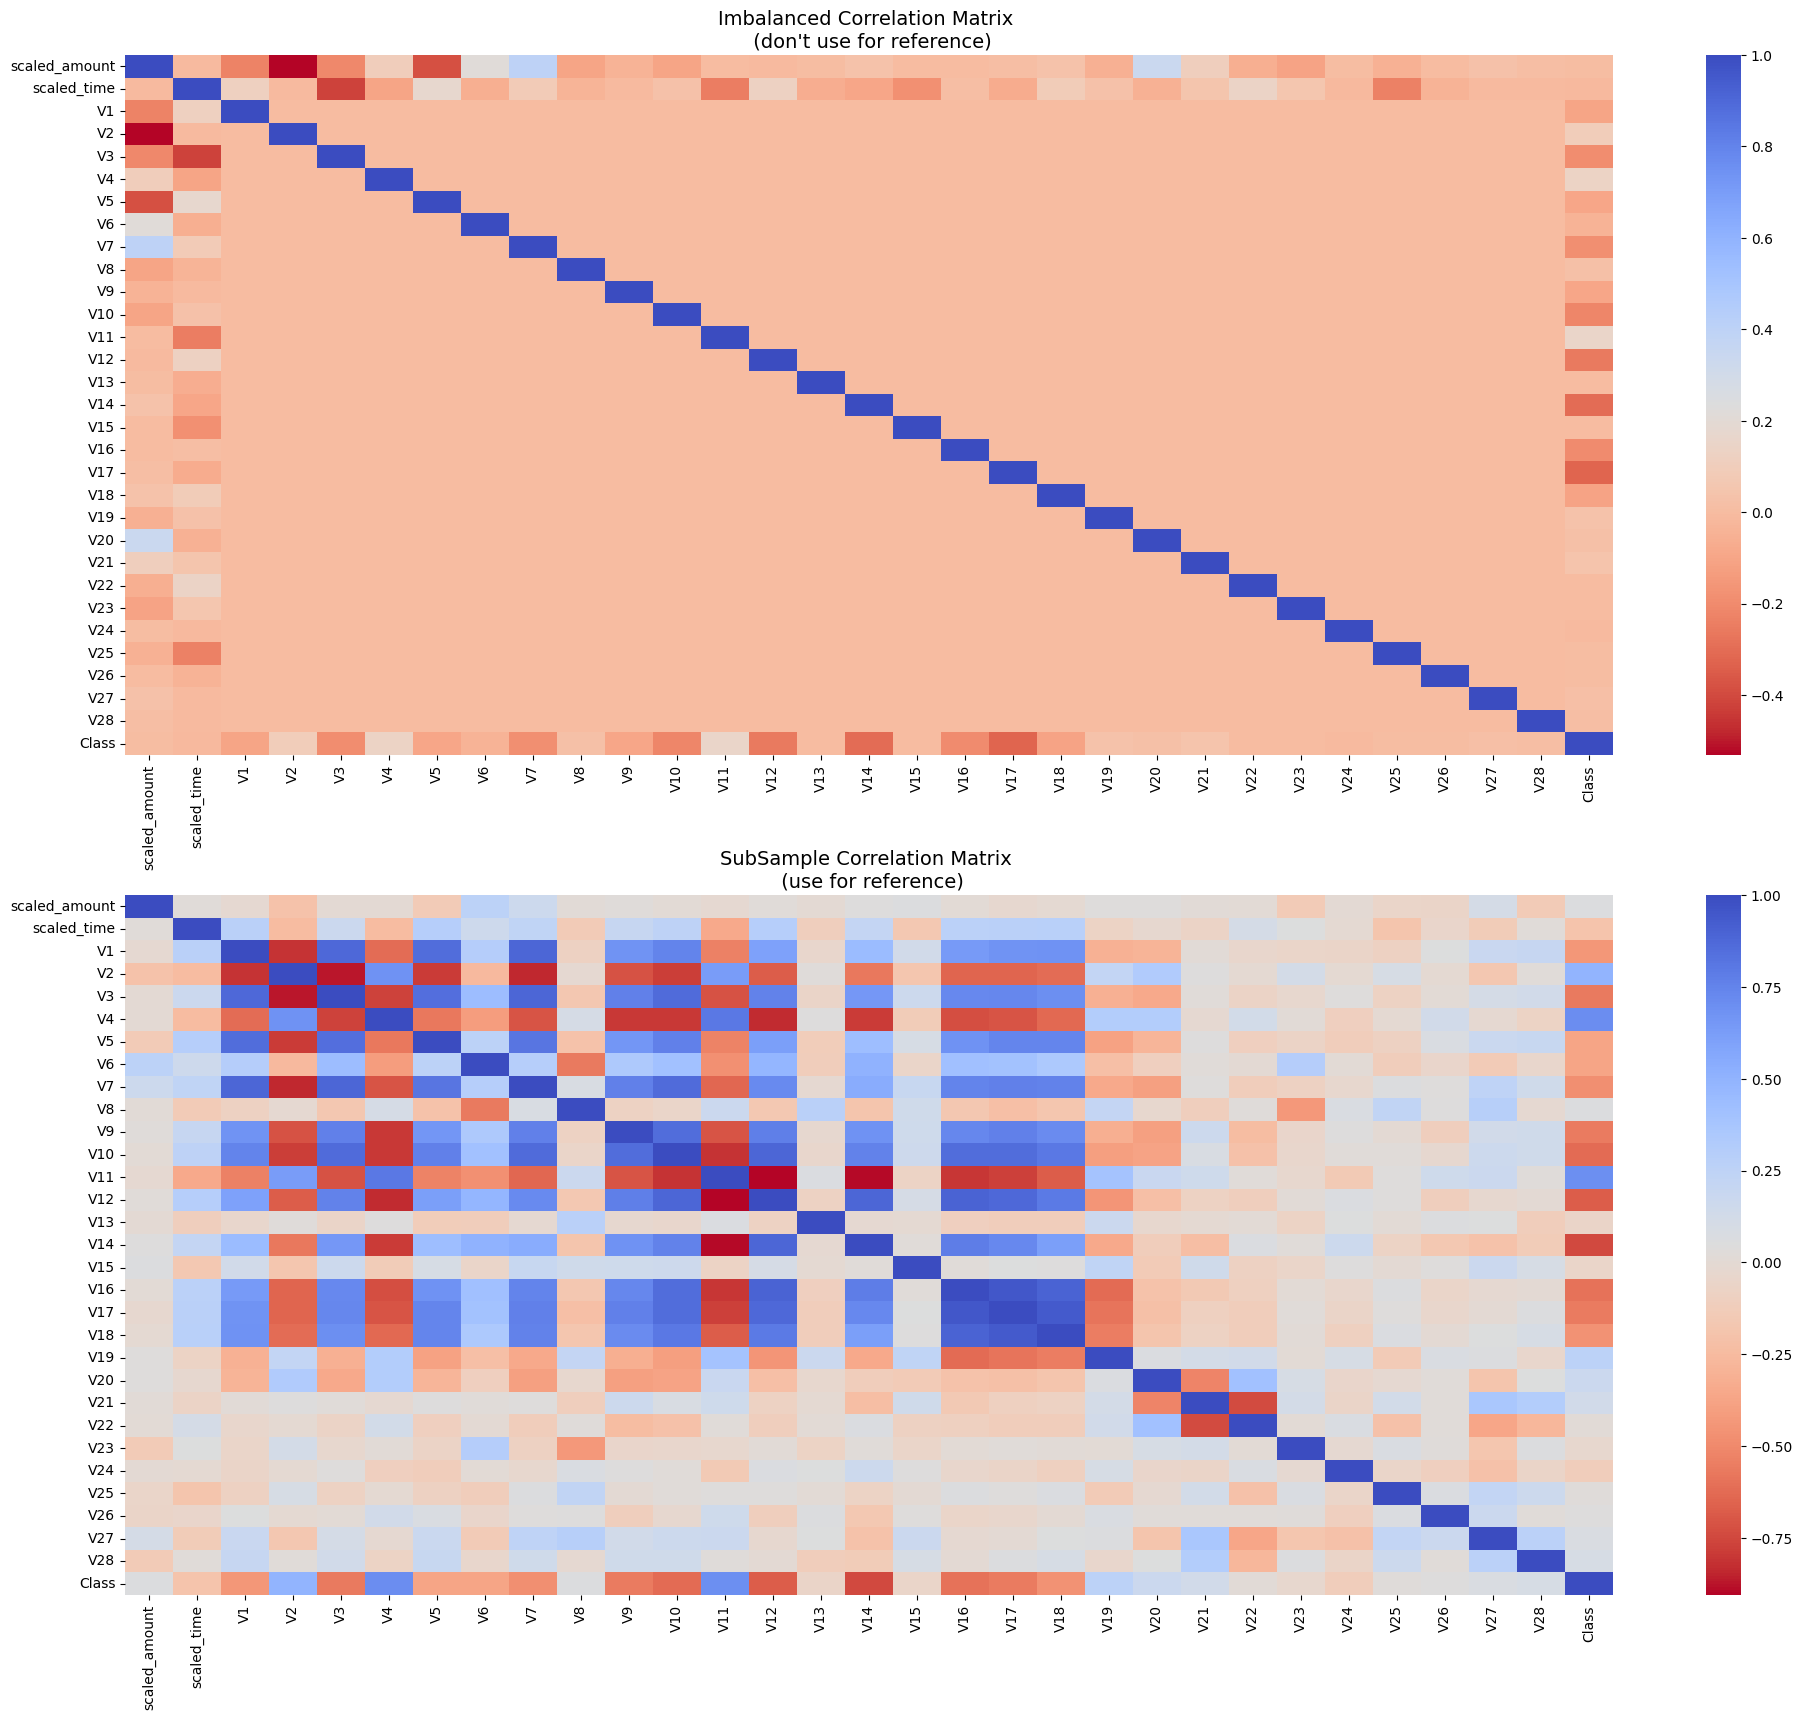

In [12]:
# Make sure we use the subsample in our correlation

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

# Entire DataFrame
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize=14)


sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix \n (use for reference)', fontsize=14)
plt.show()

C:\Users\husania\AppData\Local\Temp\ipykernel_3900\3538466111.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(v14_fraud_dist,ax=ax1, fit=norm, color='#FB8861')
C:\Users\husania\AppData\Local\Temp\ipykernel_3900\3538466111.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(v12_fraud_dist,ax

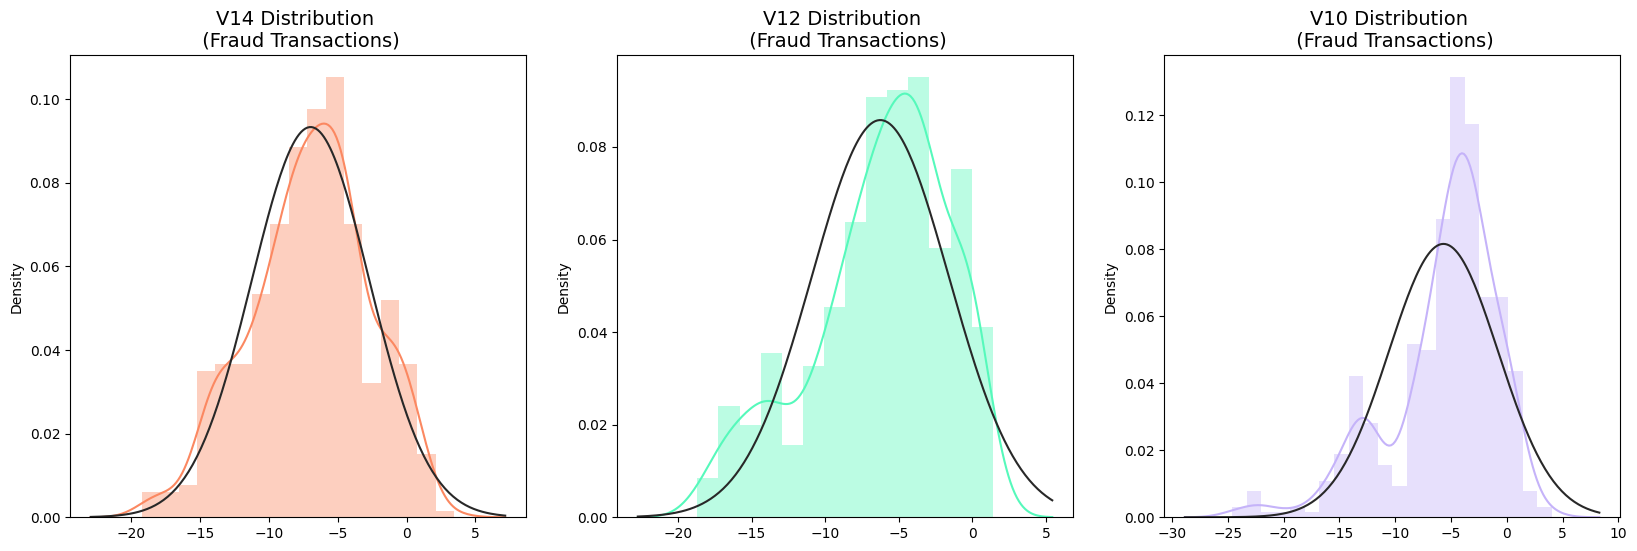

In [13]:
from scipy.stats import norm

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 6))

v14_fraud_dist = new_df['V14'].loc[new_df['Class'] == 1].values
sns.distplot(v14_fraud_dist,ax=ax1, fit=norm, color='#FB8861')
ax1.set_title('V14 Distribution \n (Fraud Transactions)', fontsize=14)

v12_fraud_dist = new_df['V12'].loc[new_df['Class'] == 1].values
sns.distplot(v12_fraud_dist,ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('V12 Distribution \n (Fraud Transactions)', fontsize=14)


v10_fraud_dist = new_df['V10'].loc[new_df['Class'] == 1].values
sns.distplot(v10_fraud_dist,ax=ax3, fit=norm, color='#C5B3F9')
ax3.set_title('V10 Distribution \n (Fraud Transactions)', fontsize=14)

plt.show()

In [14]:
# # -----> V14 Removing Outliers (Highest Negative Correlated with Labels)
v14_fraud = new_df['V14'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v14_fraud, 25), np.percentile(v14_fraud, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
v14_iqr = q75 - q25
print('iqr: {}'.format(v14_iqr))

v14_cut_off = v14_iqr * 1.5
v14_lower, v14_upper = q25 - v14_cut_off, q75 + v14_cut_off
print('Cut Off: {}'.format(v14_cut_off))
print('V14 Lower: {}'.format(v14_lower))
print('V14 Upper: {}'.format(v14_upper))

outliers = [x for x in v14_fraud if x < v14_lower or x > v14_upper]
print('Feature V14 Outliers for Fraud Cases: {}'.format(len(outliers)))
print('V10 outliers:{}'.format(outliers))

new_df = new_df.drop(new_df[(new_df['V14'] > v14_upper) | (new_df['V14'] < v14_lower)].index)
print('----' * 44)

# -----> V12 removing outliers from fraud transactions
v12_fraud = new_df['V12'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v12_fraud, 25), np.percentile(v12_fraud, 75)
v12_iqr = q75 - q25

v12_cut_off = v12_iqr * 1.5
v12_lower, v12_upper = q25 - v12_cut_off, q75 + v12_cut_off
print('V12 Lower: {}'.format(v12_lower))
print('V12 Upper: {}'.format(v12_upper))
outliers = [x for x in v12_fraud if x < v12_lower or x > v12_upper]
print('V12 outliers: {}'.format(outliers))
print('Feature V12 Outliers for Fraud Cases: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V12'] > v12_upper) | (new_df['V12'] < v12_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))
print('----' * 44)


# Removing outliers V10 Feature
v10_fraud = new_df['V10'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v10_fraud, 25), np.percentile(v10_fraud, 75)
v10_iqr = q75 - q25

v10_cut_off = v10_iqr * 1.5
v10_lower, v10_upper = q25 - v10_cut_off, q75 + v10_cut_off
print('V10 Lower: {}'.format(v10_lower))
print('V10 Upper: {}'.format(v10_upper))
outliers = [x for x in v10_fraud if x < v10_lower or x > v10_upper]
print('V10 outliers: {}'.format(outliers))
print('Feature V10 Outliers for Fraud Cases: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V10'] > v10_upper) | (new_df['V10'] < v10_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))

Quartile 25: -9.692722964972386 | Quartile 75: -4.282820849486865
iqr: 5.409902115485521
Cut Off: 8.114853173228282
V14 Lower: -17.807576138200666
V14 Upper: 3.8320323237414167
Feature V14 Outliers for Fraud Cases: 4
V10 outliers:[-19.2143254902614, -18.8220867423816, -18.0499976898594, -18.4937733551053]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
V12 Lower: -17.3430371579634
V12 Upper: 5.776973384895937
V12 outliers: [-18.6837146333443, -18.5536970096458, -18.0475965708216, -18.4311310279993]
Feature V12 Outliers for Fraud Cases: 4
Number of Instances after outliers removal: 976
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
V10 Lower: -14.89885463232024
V10 Upper: 4.92033495834214
V10 outliers: [-16.3035376590131, -19.836148

In [15]:
# New_df is from the random undersample data (fewer instances)
X = new_df.drop('Class', axis=1)
y = new_df['Class']


# T-SNE Implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

# PCA Implementation
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))

# TruncatedSVD
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X.values)
t1 = time.time()
print("Truncated SVD took {:.2} s".format(t1 - t0))

T-SNE took 7.0 s
PCA took 0.0081 s
Truncated SVD took 0.005 s


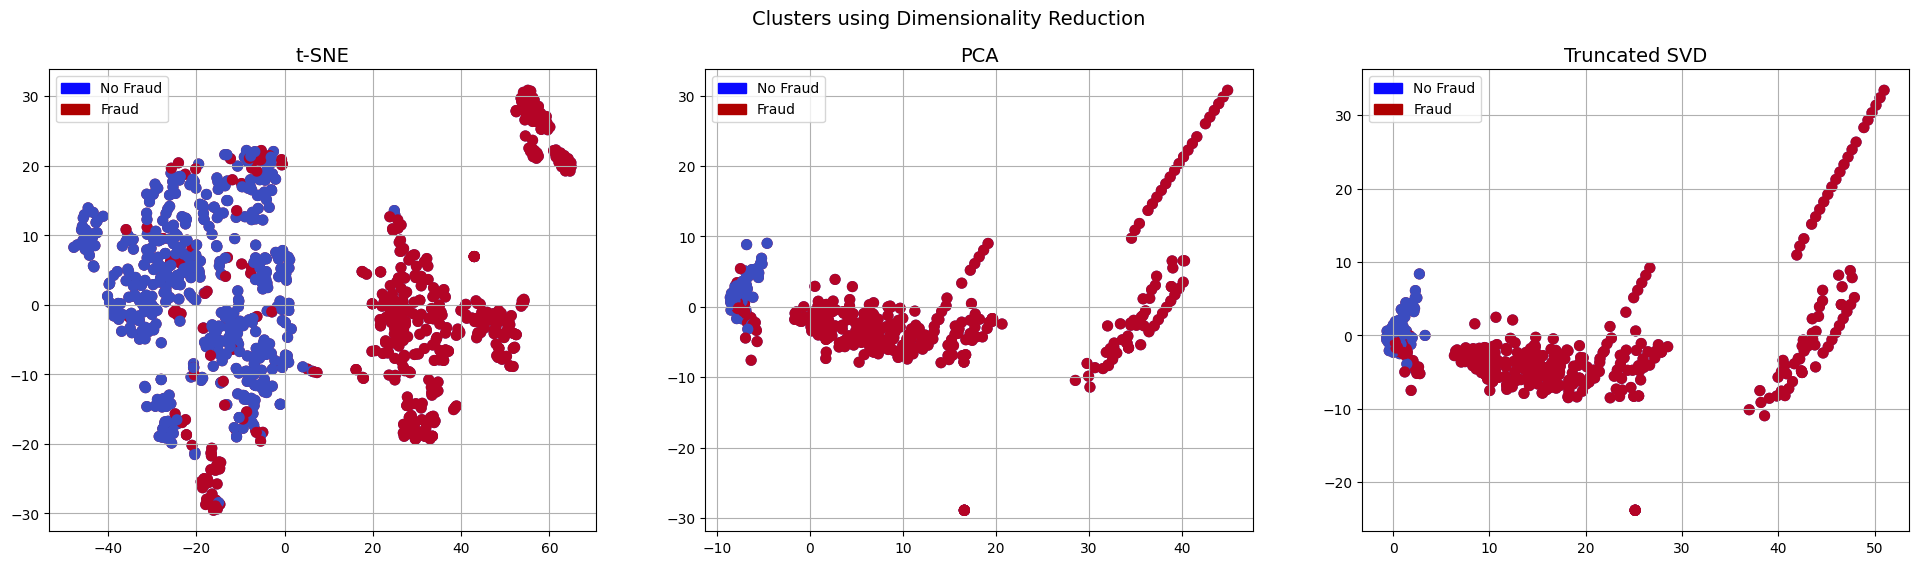

In [16]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))
# labels = ['No Fraud', 'Fraud']
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)


blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')


# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])


# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax2.set_title('PCA', fontsize=14)

ax2.grid(True)

ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)

ax3.grid(True)

ax3.legend(handles=[blue_patch, red_patch])

plt.show()

In [17]:
# Undersampling before cross validating (prone to overfit)
X = new_df.drop('Class', axis=1)
y = new_df['Class']

In [18]:
# Our data is already scaled we should split our training and test sets
from sklearn.model_selection import train_test_split

# This is explicitly used for undersampling.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
# Turn the values into an array for feeding the classification algorithms.
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [20]:
# Let's implement simple classifiers

classifiers = {
    "LogisiticRegression": LogisticRegression()
}

In [21]:
# Wow our scores are getting even high scores even when applying cross validation.
from sklearn.model_selection import cross_val_score


for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

Classifiers:  LogisticRegression Has a training score of 93.0 % accuracy score


In [22]:
# Use GridSearchCV to find the best parameters.
from sklearn.model_selection import GridSearchCV


# Logistic Regression 
log_reg_params = {"penalty": ['l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}



grid_log_reg = GridSearchCV(LogisticRegression(max_iter=1000), log_reg_params)
grid_log_reg.fit(X_train, y_train)
# We automatically get the logistic regression with the best parameters.
log_reg = grid_log_reg.best_estimator_

knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

In [23]:
log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=5)
print('Logistic Regression Cross Validation Score: ', round(log_reg_score.mean() * 100, 2).astype(str) + '%')

Logistic Regression Cross Validation Score:  93.94%


In [24]:
# We will undersample during cross validating
undersample_X = df.drop('Class', axis=1)
undersample_y = df['Class']

for train_index, test_index in sss.split(undersample_X, undersample_y):
    print("Train:", train_index, "Test:", test_index)
    undersample_Xtrain, undersample_Xtest = undersample_X.iloc[train_index], undersample_X.iloc[test_index]
    undersample_ytrain, undersample_ytest = undersample_y.iloc[train_index], undersample_y.iloc[test_index]
    
undersample_Xtrain = undersample_Xtrain.values
undersample_Xtest = undersample_Xtest.values
undersample_ytrain = undersample_ytrain.values
undersample_ytest = undersample_ytest.values 

undersample_accuracy = []
undersample_precision = []
undersample_recall = []
undersample_f1 = []
undersample_auc = []

# Implementing NearMiss Technique 
# Distribution of NearMiss (Just to see how it distributes the labels we won't use these variables)
nearmiss = NearMiss()
X_nearmiss, y_nearmiss = nearmiss.fit_resample(undersample_X.values, undersample_y.values)
print('NearMiss Label Distribution: {}'.format(Counter(y_nearmiss)))
# Cross Validating the right way

for train, test in sss.split(undersample_Xtrain, undersample_ytrain):
    undersample_pipeline = imbalanced_make_pipeline(NearMiss(sampling_strategy='majority'), log_reg) # SMOTE happens during Cross Validation not before..
    undersample_model = undersample_pipeline.fit(undersample_Xtrain[train], undersample_ytrain[train])
    undersample_prediction = undersample_model.predict(undersample_Xtrain[test])
    
    undersample_accuracy.append(undersample_pipeline.score(original_Xtrain[test], original_ytrain[test]))
    undersample_precision.append(precision_score(original_ytrain[test], undersample_prediction))
    undersample_recall.append(recall_score(original_ytrain[test], undersample_prediction))
    undersample_f1.append(f1_score(original_ytrain[test], undersample_prediction))
    undersample_auc.append(roc_auc_score(original_ytrain[test], undersample_prediction))

Train: [ 51370  52397  52681 ... 284804 284805 284806] Test: [    0     1     2 ... 56965 56966 56967]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 51370  52397  52681 ... 113928 113929 113930]
Train: [     0      1      2 ... 284804 284805 284806] Test: [111159 111455 111684 ... 170885 170886 170887]
Train: [     0      1      2 ... 284804 284805 284806] Test: [167769 168281 170249 ... 227857 227859 227860]
Train: [     0      1      2 ... 227857 227859 227860] Test: [218702 220210 220656 ... 284804 284805 284806]
NearMiss Label Distribution: Counter({0: 492, 1: 492})


In [25]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict
# Create a DataFrame with all the scores and the classifiers names.

log_reg_pred = cross_val_predict(log_reg, X_train, y_train, cv=5,
                             method="decision_function")



In [26]:
from sklearn.metrics import roc_auc_score

print('Logistic Regression: ', roc_auc_score(y_train, log_reg_pred))

Logistic Regression:  0.9775526392696605


In [27]:
log_fpr, log_tpr, log_thresold = roc_curve(y_train, log_reg_pred)

In [28]:
def logistic_roc_curve(log_fpr, log_tpr):
    plt.figure(figsize=(12,8))
    plt.title('Logistic Regression ROC Curve', fontsize=16)
    plt.plot(log_fpr, log_tpr, 'b-', linewidth=2)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.axis([-0.01,1,0,1])

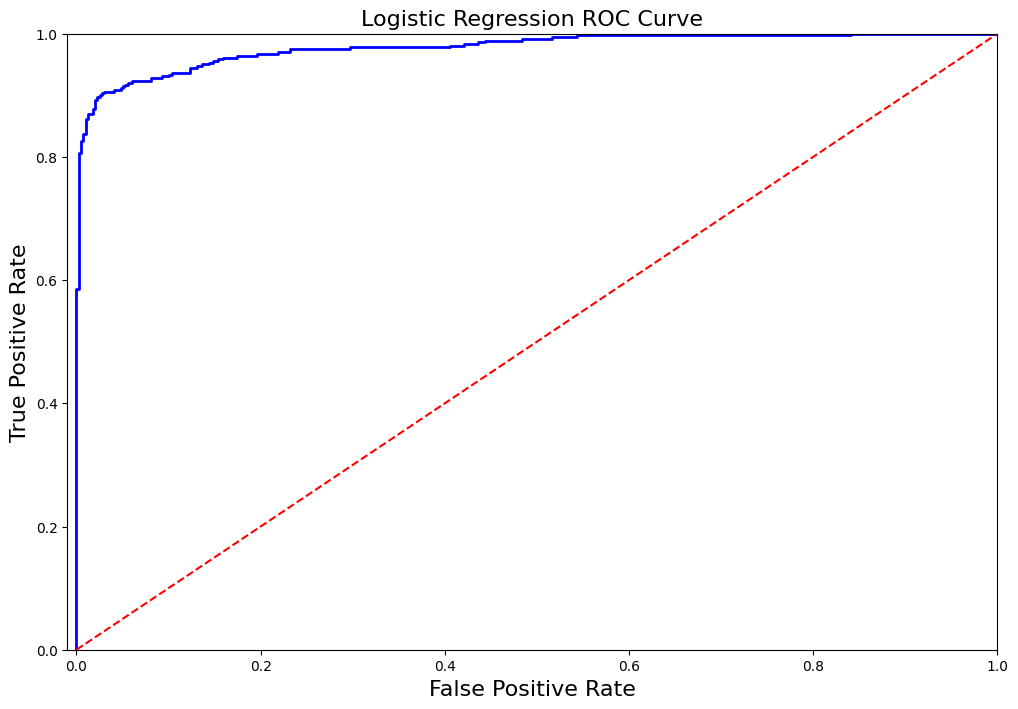

In [29]:
logistic_roc_curve(log_fpr, log_tpr)
plt.show()

In [30]:
from sklearn.metrics import precision_recall_curve

precision, recall, threshold = precision_recall_curve(y_train, log_reg_pred)

In [31]:
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
y_pred = log_reg.predict(X_train)

# Overfitting Case
print('---' * 45)
print('Overfitting: \n')
print('Recall Score: {:.2f}'.format(recall_score(y_train, y_pred)))
print('Precision Score: {:.2f}'.format(precision_score(y_train, y_pred)))
print('F1 Score: {:.2f}'.format(f1_score(y_train, y_pred)))
print('Accuracy Score: {:.2f}'.format(accuracy_score(y_train, y_pred)))
print('---' * 45)

# How it should look like
print('---' * 45)
print('How it should be:\n')
print("Accuracy Score: {:.2f}".format(np.mean(undersample_accuracy)))
print("Precision Score: {:.2f}".format(np.mean(undersample_precision)))
print("Recall Score: {:.2f}".format(np.mean(undersample_recall)))
print("F1 Score: {:.2f}".format(np.mean(undersample_f1)))
print('---' * 45)

---------------------------------------------------------------------------------------------------------------------------------------
Overfitting: 

Recall Score: 0.91
Precision Score: 0.76
F1 Score: 0.82
Accuracy Score: 0.82
---------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------
How it should be:

Accuracy Score: 0.79
Precision Score: 0.00
Recall Score: 0.23
F1 Score: 0.00
---------------------------------------------------------------------------------------------------------------------------------------


In [32]:
undersample_y_score = log_reg.decision_function(original_Xtest)

In [33]:
from sklearn.metrics import average_precision_score

undersample_average_precision = average_precision_score(original_ytest, undersample_y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      undersample_average_precision))

Average precision-recall score: 0.08


Text(0.5, 1.0, 'UnderSampling Precision-Recall curve: \n Average Precision-Recall Score =0.08')

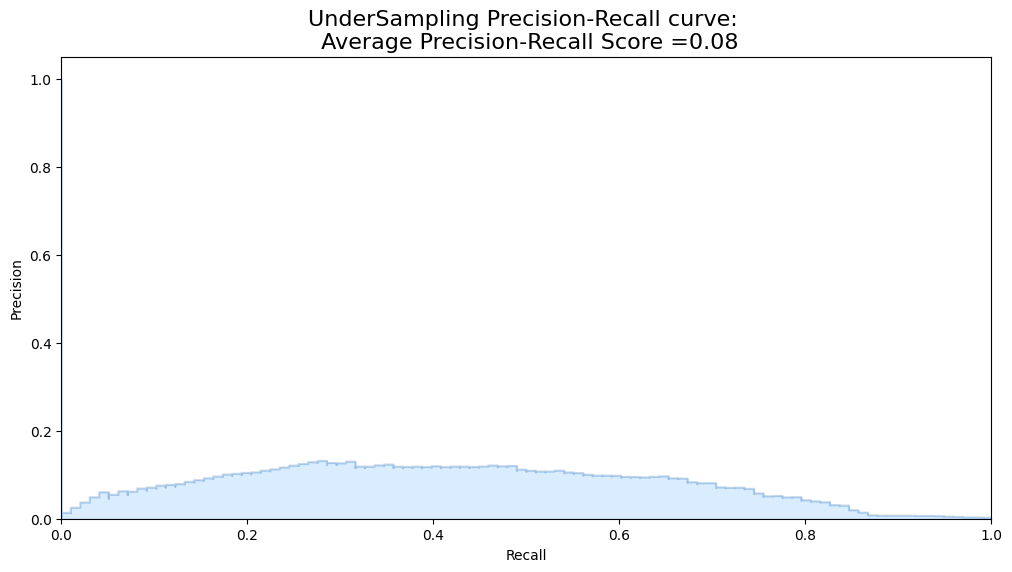

In [34]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,6))

precision, recall, _ = precision_recall_curve(original_ytest, undersample_y_score)

plt.step(recall, precision, color='#004a93', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='#48a6ff')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('UnderSampling Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(
          undersample_average_precision), fontsize=16)

In [35]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV


print('Length of X (train): {} | Length of y (train): {}'.format(len(original_Xtrain), len(original_ytrain)))
print('Length of X (test): {} | Length of y (test): {}'.format(len(original_Xtest), len(original_ytest)))

# List to append the score and then find the average
accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

# Classifier with optimal parameters
# log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm = LogisticRegression()




rand_log_reg = RandomizedSearchCV(LogisticRegression(max_iter=1000), log_reg_params, n_iter=4)


# Implementing SMOTE Technique 
# Cross Validating the right way
# Parameters
log_reg_params = {"penalty": ['l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
for train, test in sss.split(original_Xtrain, original_ytrain):
    pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_log_reg) # SMOTE happens during Cross Validation not before..
    model = pipeline.fit(original_Xtrain[train], original_ytrain[train])
    best_est = rand_log_reg.best_estimator_
    prediction = best_est.predict(original_Xtrain[test])
    
    accuracy_lst.append(pipeline.score(original_Xtrain[test], original_ytrain[test]))
    precision_lst.append(precision_score(original_ytrain[test], prediction))
    recall_lst.append(recall_score(original_ytrain[test], prediction))
    f1_lst.append(f1_score(original_ytrain[test], prediction))
    auc_lst.append(roc_auc_score(original_ytrain[test], prediction))
    
print('---' * 45)
print('')
print("accuracy: {}".format(np.mean(accuracy_lst)))
print("precision: {}".format(np.mean(precision_lst)))
print("recall: {}".format(np.mean(recall_lst)))
print("f1: {}".format(np.mean(f1_lst)))
print('---' * 45)

Length of X (train): 227846 | Length of y (train): 227846
Length of X (test): 56961 | Length of y (test): 56961
---------------------------------------------------------------------------------------------------------------------------------------

accuracy: 0.943054298532385
precision: 0.06226783513316063
recall: 0.9137617656604998
f1: 0.11478304801423897
---------------------------------------------------------------------------------------------------------------------------------------


In [36]:
labels = ['No Fraud', 'Fraud']
smote_prediction = best_est.predict(original_Xtest)
print(classification_report(original_ytest, smote_prediction, target_names=labels))

              precision    recall  f1-score   support

    No Fraud       1.00      0.99      0.99     56863
       Fraud       0.11      0.86      0.19        98

    accuracy                           0.99     56961
   macro avg       0.55      0.92      0.59     56961
weighted avg       1.00      0.99      0.99     56961



In [37]:
y_score = best_est.decision_function(original_Xtest)

In [38]:
average_precision = average_precision_score(original_ytest, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.74


In [39]:
# SMOTE Technique (OverSampling) After splitting and Cross Validating
sm = SMOTE(sampling_strategy='minority', random_state=42)
# Xsm_train, ysm_train = sm.fit_sample(X_train, y_train)


# This will be the data were we are going to 
Xsm_train, ysm_train = sm.fit_resample(original_Xtrain, original_ytrain)

In [40]:
# We Improve the score by 2% points approximately 
# Implement GridSearchCV and the other models.

# Logistic Regression
t0 = time.time()
log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm.fit(Xsm_train, ysm_train)
t1 = time.time()
print("Fitting oversample data took :{} sec".format(t1 - t0))

Fitting oversample data took :5.855199813842773 sec


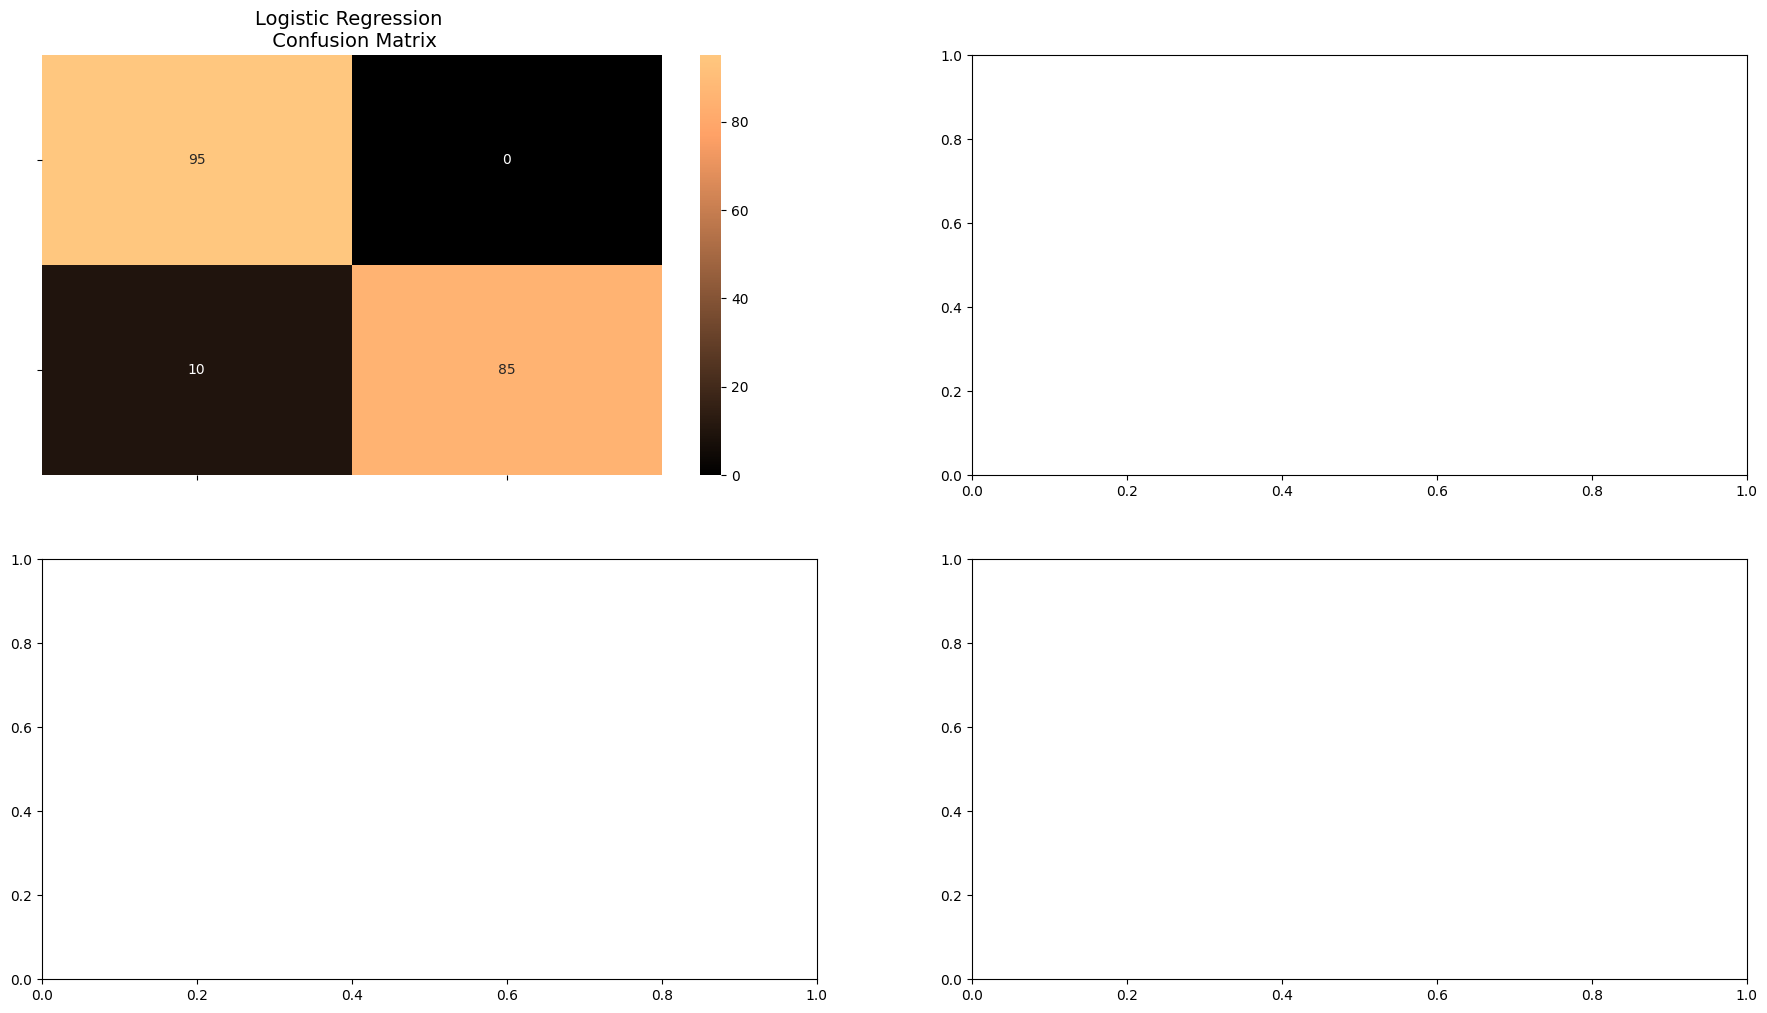

In [41]:
from sklearn.metrics import confusion_matrix

# Logistic Regression fitted using SMOTE technique
y_pred_log_reg = log_reg_sm.predict(X_test)




log_reg_cf = confusion_matrix(y_test, y_pred_log_reg)


fig, ax = plt.subplots(2, 2,figsize=(22,12))


sns.heatmap(log_reg_cf, ax=ax[0][0], annot=True, cmap=plt.cm.copper)
ax[0, 0].set_title("Logistic Regression \n Confusion Matrix", fontsize=14)
ax[0, 0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0, 0].set_yticklabels(['', ''], fontsize=14, rotation=360)




plt.show()

In [109]:
undersample_Xtest.shape


(56961, 30)

In [110]:
original_Xtest.shape

(56961, 30)

In [42]:
from sklearn.metrics import classification_report


print('Logistic Regression:')
print(classification_report(y_test, y_pred_log_reg))

Logistic Regression:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95        95
           1       1.00      0.89      0.94        95

    accuracy                           0.95       190
   macro avg       0.95      0.95      0.95       190
weighted avg       0.95      0.95      0.95       190



In [43]:
# Final Score in the test set of logistic regression
from sklearn.metrics import accuracy_score

# Logistic Regression with Under-Sampling
y_pred = log_reg.predict(X_test)
undersample_score = accuracy_score(y_test, y_pred)



# Logistic Regression with SMOTE Technique (Better accuracy with SMOTE t)
y_pred_sm = best_est.predict(original_Xtest)
oversample_score = accuracy_score(original_ytest, y_pred_sm)


d = {'Technique': ['Random UnderSampling', 'Oversampling (SMOTE)'], 'Score': [undersample_score, oversample_score]}
final_df = pd.DataFrame(data=d)

# Move column
score = final_df['Score']
final_df.drop('Score', axis=1, inplace=True)
final_df.insert(1, 'Score', score)

# Note how high is accuracy score it can be misleading! 
final_df

,Technique,Score
0,Random UnderSampling,0.947368
1,Oversampling (SMOTE),0.987799


In [44]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers import Dense
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy

n_inputs = X_train.shape[1]

undersample_model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

In [45]:
undersample_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                930       
                                                                 
 dense_1 (Dense)             (None, 32)                992       
                                                                 
 dense_2 (Dense)             (None, 2)                 66        
                                                                 
Total params: 1988 (7.77 KB)
Trainable params: 1988 (7.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [46]:
undersample_model.compile(Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [47]:
undersample_model.fit(X_train, y_train, validation_split=0.2, batch_size=25, epochs=20, shuffle=True, verbose=2)

Epoch 1/20


25/25 - 1s - loss: 0.9908 - accuracy: 0.5651 - val_loss: 0.5220 - val_accuracy: 0.7105 - 1s/epoch - 49ms/step
Epoch 2/20
25/25 - 0s - loss: 0.4199 - accuracy: 0.8188 - val_loss: 0.4180 - val_accuracy: 0.8355 - 78ms/epoch - 3ms/step
Epoch 3/20
25/25 - 0s - loss: 0.3321 - accuracy: 0.8979 - val_loss: 0.3594 - val_accuracy: 0.8947 - 84ms/epoch - 3ms/step
Epoch 4/20
25/25 - 0s - loss: 0.2744 - accuracy: 0.9292 - val_loss: 0.3213 - val_accuracy: 0.8882 - 76ms/epoch - 3ms/step
Epoch 5/20
25/25 - 0s - loss: 0.2305 - accuracy: 0.9390 - val_loss: 0.2923 - val_accuracy: 0.9079 - 77ms/epoch - 3ms/step
Epoch 6/20
25/25 - 0s - loss: 0.1944 - accuracy: 0.9456 - val_loss: 0.2742 - val_accuracy: 0.9145 - 76ms/epoch - 3ms/step
Epoch 7/20
25/25 - 0s - loss: 0.1684 - accuracy: 0.9473 - val_loss: 0.2600 - val_accuracy: 0.9079 - 78ms/epoch - 3ms/step
Epoch 8/20
25/25 - 0s - loss: 0.1499 - accuracy: 0.9522 - val_loss: 0.2532 - val_accuracy: 0.9079 - 76ms/epoch - 3ms/step
Epoch 9/20
25/25 - 0s -

In [48]:
undersample_model.save('C:\\Adatok\\2023\\Egyetem\\GepiTanulas\\Homework\\Models\\UnderSampleModel')

INFO:tensorflow:Assets written to: C:\Adatok\2023\Egyetem\GepiTanulas\Homework\Models\UnderSampleModel\assets


INFO:tensorflow:Assets written to: C:\Adatok\2023\Egyetem\GepiTanulas\Homework\Models\UnderSampleModel\assets


In [49]:
undersample_predictions = undersample_model.predict(original_Xtest, batch_size=200, verbose=0)

In [50]:
undersample_fraud_predictions = undersample_model.predict(original_Xtest, batch_size=200, verbose=0)

In [51]:
import numpy as np

# Assuming original_ytest and undersample_fraud_predictions are NumPy arrays
unique_values_original_ytest = np.unique(original_ytest)
unique_values_undersample_fraud_predictions = np.unique(undersample_fraud_predictions)

print("Unique values in original_ytest:", unique_values_original_ytest)
print("Unique values in undersample_fraud_predictions:", unique_values_undersample_fraud_predictions)

Unique values in original_ytest: [0 1]
Unique values in undersample_fraud_predictions: [1.24456287e-15 3.64400477e-15 1.07108985e-14 ... 9.99999762e-01
 9.99999881e-01 1.00000000e+00]


In [52]:
import itertools

# Create a confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [53]:
threshold = 0.5
undersample_fraud_predictions_binary = (undersample_fraud_predictions > threshold).astype(int)

In [54]:
print(original_ytest.dtype)
print(undersample_fraud_predictions_binary.dtype)

int64
int32


In [55]:
threshold = 0.5
undersample_fraud_predictions_binary = (undersample_fraud_predictions > threshold).astype(int)

# Check data types and shapes
print(original_ytest.dtype)
print(undersample_fraud_predictions_binary.dtype)
print(original_ytest.shape)
print(undersample_fraud_predictions_binary.shape)

# Ensure binary labels
print(np.unique(original_ytest))
print(np.unique(undersample_fraud_predictions_binary))

int64
int32
(56961,)
(56961, 2)
[0 1]
[0 1]


int64
int32
(56961,)
(56961,)
[0 1]
[0 1]
Normalized confusion matrix
[[0.96447602 0.03552398]
 [0.07142857 0.92857143]]


Normalized confusion matrix
[[1. 0.]
 [0. 1.]]


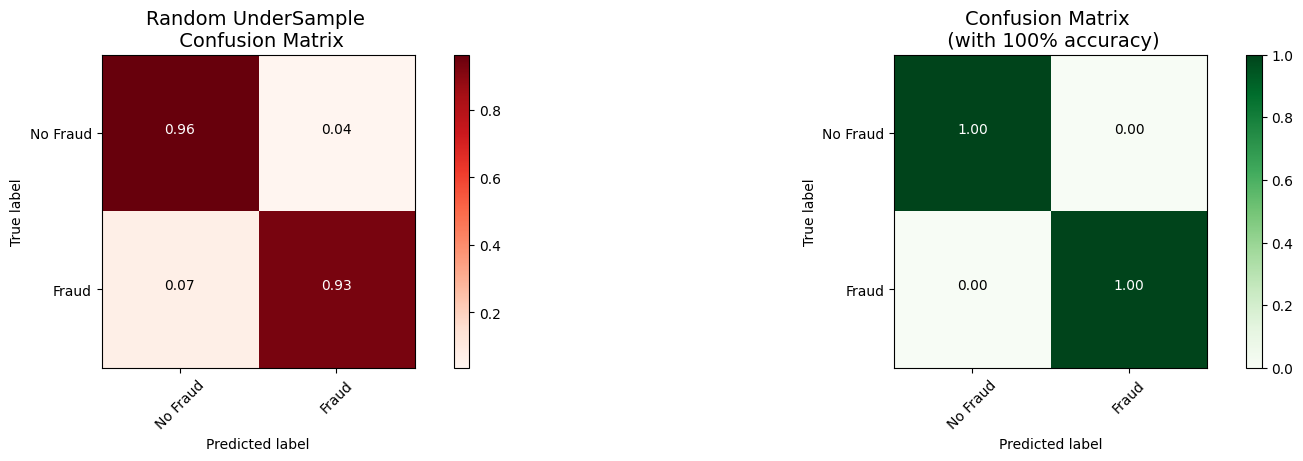

In [56]:
threshold = 0.5
undersample_fraud_predictions_binary = (undersample_fraud_predictions[:, 1] > threshold).astype(int)

# Check data types and shapes
print(original_ytest.dtype)
print(undersample_fraud_predictions_binary.dtype)
print(original_ytest.shape)
print(undersample_fraud_predictions_binary.shape)

# Ensure binary labels
print(np.unique(original_ytest))
print(np.unique(undersample_fraud_predictions_binary))

undersample_cm = confusion_matrix(original_ytest, undersample_fraud_predictions_binary)
actual_cm = confusion_matrix(original_ytest, original_ytest)
labels = ['No Fraud', 'Fraud']

fig = plt.figure(figsize=(16,8))

fig.add_subplot(221)
plot_confusion_matrix(undersample_cm, labels, title="Random UnderSample \n Confusion Matrix", cmap=plt.cm.Reds)

fig.add_subplot(222)
plot_confusion_matrix(actual_cm, labels, title="Confusion Matrix \n (with 100% accuracy)", cmap=plt.cm.Greens)

In [57]:
n_inputs = Xsm_train.shape[1]

oversample_model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

In [58]:
oversample_model.compile(Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [59]:
oversample_model.fit(Xsm_train, ysm_train, validation_split=0.2, batch_size=300, epochs=20, shuffle=True, verbose=2)

Epoch 1/20
1214/1214 - 3s - loss: 0.0722 - accuracy: 0.9734 - val_loss: 0.0251 - val_accuracy: 0.9927 - 3s/epoch - 3ms/step
Epoch 2/20
1214/1214 - 2s - loss: 0.0142 - accuracy: 0.9967 - val_loss: 0.0068 - val_accuracy: 0.9997 - 2s/epoch - 2ms/step
Epoch 3/20
1214/1214 - 2s - loss: 0.0076 - accuracy: 0.9985 - val_loss: 0.0041 - val_accuracy: 0.9998 - 2s/epoch - 2ms/step
Epoch 4/20
1214/1214 - 2s - loss: 0.0053 - accuracy: 0.9990 - val_loss: 0.0026 - val_accuracy: 1.0000 - 2s/epoch - 2ms/step
Epoch 5/20
1214/1214 - 2s - loss: 0.0041 - accuracy: 0.9992 - val_loss: 0.0015 - val_accuracy: 1.0000 - 2s/epoch - 2ms/step
Epoch 6/20
1214/1214 - 2s - loss: 0.0034 - accuracy: 0.9993 - val_loss: 0.0013 - val_accuracy: 0.9999 - 2s/epoch - 2ms/step
Epoch 7/20
1214/1214 - 2s - loss: 0.0030 - accuracy: 0.9994 - val_loss: 0.0012 - val_accuracy: 1.0000 - 2s/epoch - 2ms/step
Epoch 8/20
1214/1214 - 2s - loss: 0.0026 - accuracy: 0.9995 - val_loss: 0.0012 - val_accuracy: 1.0000 - 2s/epoch - 2ms/step
Epoch 9/

In [60]:
oversample_model.save('C:\\Adatok\\2023\\Egyetem\\GepiTanulas\\Homework\\Models\\OverSampleModel')

INFO:tensorflow:Assets written to: C:\Adatok\2023\Egyetem\GepiTanulas\Homework\Models\OverSampleModel\assets


INFO:tensorflow:Assets written to: C:\Adatok\2023\Egyetem\GepiTanulas\Homework\Models\OverSampleModel\assets


In [61]:
oversample_predictions = oversample_model.predict(original_Xtest, batch_size=200, verbose=0)

In [62]:
oversample_fraud_predictions = oversample_model.predict(original_Xtest, batch_size=200, verbose=0)

int64
int32
(56961,)
(56961,)
[0 1]
[0 1]
Normalized confusion matrix
[[9.99876897e-01 1.23102896e-04]
 [3.46938776e-01 6.53061224e-01]]
Normalized confusion matrix
[[1. 0.]
 [0. 1.]]


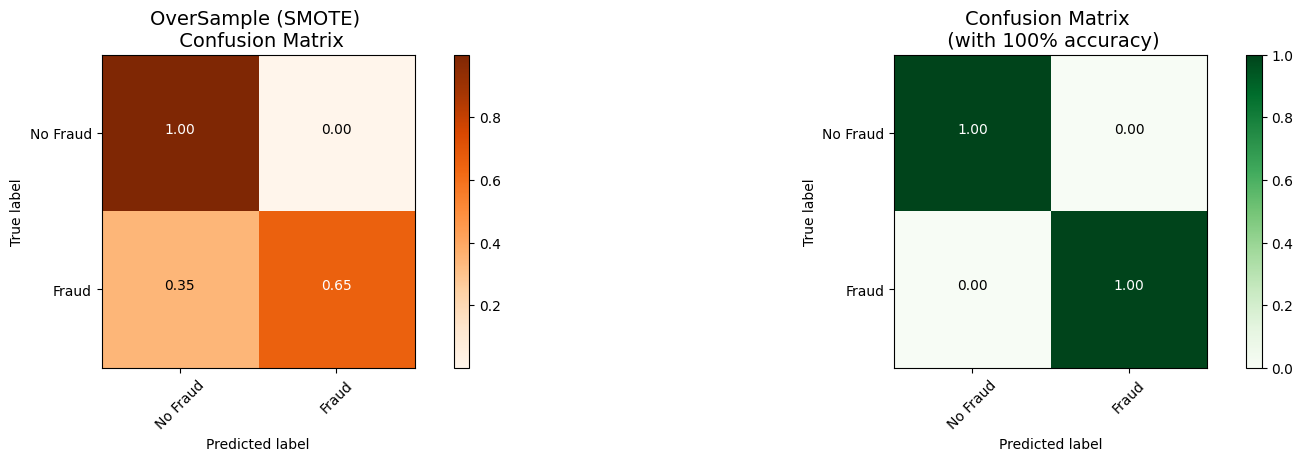

In [63]:

threshold = 0.5
oversample_fraud_predictions_binary = (oversample_fraud_predictions[:, 1] > threshold).astype(int)

# Check data types and shapes
print(original_ytest.dtype)
print(oversample_fraud_predictions_binary.dtype)
print(original_ytest.shape)
print(oversample_fraud_predictions_binary.shape)

# Ensure binary labels
print(np.unique(original_ytest))
print(np.unique(oversample_fraud_predictions_binary))

oversample_smote = confusion_matrix(original_ytest, oversample_fraud_predictions_binary)
actual_cm = confusion_matrix(original_ytest, original_ytest)
labels = ['No Fraud', 'Fraud']

fig = plt.figure(figsize=(16,8))

fig.add_subplot(221)
plot_confusion_matrix(oversample_smote, labels, title="OverSample (SMOTE) \n Confusion Matrix", cmap=plt.cm.Oranges)

fig.add_subplot(222)
plot_confusion_matrix(actual_cm, labels, title="Confusion Matrix \n (with 100% accuracy)", cmap=plt.cm.Greens)

In [64]:
classification_report(original_ytest, oversample_fraud_predictions_binary)

'              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00     56863\n           1       0.90      0.65      0.76        98\n\n    accuracy                           1.00     56961\n   macro avg       0.95      0.83      0.88     56961\nweighted avg       1.00      1.00      1.00     56961\n'

In [65]:
loaded_oversample_model = keras.models.load_model('C:\\Adatok\\2023\\Egyetem\\GepiTanulas\\Homework\\Models\\OverSampleModel')
loaded_undersample_model = keras.models.load_model('C:\\Adatok\\2023\\Egyetem\\GepiTanulas\\Homework\\Models\\UnderSampleModel')


In [66]:
loaded_oversample_model.summary()
loaded_undersample_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 30)                930       
                                                                 
 dense_4 (Dense)             (None, 32)                992       
                                                                 
 dense_5 (Dense)             (None, 2)                 66        
                                                                 
Total params: 1988 (7.77 KB)
Trainable params: 1988 (7.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                930       
                                                                 
 d

In [113]:
print(undersample_Xtest.shape)
print(original_Xtest.shape)

(56961, 30)
(56961, 30)
